## Lead Scoring with Logistic Regression
##### Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads

In [183]:
import warnings
warnings.filterwarnings('ignore')

In [184]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)

## [Step 1. Reading and Understanding the Data](#step1)

## [Step 2.Data Cleaning and EDA](#step2)
[2.1 Missing value check](#step2.1)<br>
[2.2 Cleaning and Visualizing categorical variables](#step2.2)<br>
[2.3 Cleaning and Visualizing numerical variables](#step2.3)<br>
[2.4 Outlier Treatment](#step2.4)<br>
[2.5 Check for duplicates](#step2.5)<br>
[2.6 Check for data type conversion](#step2.6)<br>

## [Step 3. Preprocessing and Data Preparation](#step3)
[3.1 Adding Derived variables](#step3.1)<br>
[3.2 Categorizing variables](#step3.2)<br>
[3.3 Creating dummy variables](#step3.3)<br>
[3.4 Dropping unncessary Columns](#step3.4)<br>

## [Step 4. Creating Training and Testing Sets and scaling the features](#step4)
[4.1 Dividing the data into train and test set](#step4.1)<br>
[4.2 Scaling numeric variables](#step4.2)<br>
[4.3 Feature elimination](#step4.3)<br>

## [Step 5. Model Building](#Step5)



The above steps will be covered to build the model. 

## Step 1. Reading and Understanding the Data<a id='step1'></a>

In [185]:
lead_data = pd.read_csv('Leads.csv')
lead_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [186]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [187]:
lead_data.shape

(9240, 37)

In [188]:
lead_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Lead Number,9240.0,617188.435606,23405.995698,579533.0,596484.5,615479.0,637387.25,660737.0
Converted,9240.0,0.385390,0.486714,0.0,0.0,0.0,1.00,1.0
TotalVisits,9103.0,3.445238,4.854853,0.0,1.0,3.0,5.00,251.0
Total Time Spent on Website,9240.0,487.698268,548.021466,0.0,12.0,248.0,936.00,2272.0
Page Views Per Visit,9103.0,2.362820,2.161418,0.0,1.0,2.0,3.00,55.0
Asymmetrique Activity Score,5022.0,14.306252,1.386694,7.0,14.0,14.0,15.00,18.0
Asymmetrique Profile Score,5022.0,16.344883,1.811395,11.0,15.0,16.0,18.00,20.0


Out of 37 columns above 5 seems to be numeric ones

In [189]:
#Checking data imbalance
lead_data['Converted'].mean()

0.3853896103896104

#### Only 38% of the leads were converted

In [190]:
lead_data.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [191]:
#renaming lengthy names of columns
lead_data = lead_data.rename({'Total Time Spent on Website':'Website Time','What is your current occupation': 'Occupation','What matters most to you in choosing a course':'Reason','A free copy of Mastering The Interview':'Free copy required'}, axis=1)
lead_data.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Website Time', 'Page Views Per Visit', 'Last Activity', 'Country',
       'Specialization', 'How did you hear about X Education', 'Occupation',
       'Reason', 'Search', 'Magazine', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Digital Advertisement',
       'Through Recommendations', 'Receive More Updates About Our Courses',
       'Tags', 'Lead Quality', 'Update me on Supply Chain Content',
       'Get updates on DM Content', 'Lead Profile', 'City',
       'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque', 'Free copy required',
       'Last Notable Activity'],
      dtype='object')

## Step 2.Data Cleaning and EDA<a id='step2'></a>

#### 2.1 Missing value check<a id=step2.1></a>


In [192]:
# sum it up to check how many rows have all missing values
lead_data.isnull().all(axis=1).sum()

0

In [193]:
# % of the missing values (column-wise)
round(100*(lead_data.isnull().sum()/len(lead_data.index)), 2)


Prospect ID                                  0.00
Lead Number                                  0.00
Lead Origin                                  0.00
Lead Source                                  0.39
Do Not Email                                 0.00
Do Not Call                                  0.00
Converted                                    0.00
TotalVisits                                  1.48
Website Time                                 0.00
Page Views Per Visit                         1.48
Last Activity                                1.11
Country                                     26.63
Specialization                              15.56
How did you hear about X Education          23.89
Occupation                                  29.11
Reason                                      29.32
Search                                       0.00
Magazine                                     0.00
Newspaper Article                            0.00
X Education Forums                           0.00


#### We do see lots of missing values and most of columns have greater than 20% missing values. Lets divide the columns into categorical and numerical and handle them one by one.

#### 2.2 Cleaning and Visualizing categorical variables<a id='step2.2'></a>

In [194]:
lead_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Website Time,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,Occupation,Reason,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,Free copy required,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [195]:
cat_cols = ['Lead Origin', 'Lead Source','Do Not Email', 'Do Not Call', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'Occupation',
       'Reason', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index','I agree to pay the amount through cheque',
       'Free copy required', 'Last Notable Activity']

In [196]:
cat_cols

['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Last Activity',
 'Country',
 'Specialization',
 'How did you hear about X Education',
 'Occupation',
 'Reason',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Tags',
 'Lead Quality',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'Lead Profile',
 'City',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'I agree to pay the amount through cheque',
 'Free copy required',
 'Last Notable Activity']

In [197]:
round(100*(lead_data[cat_cols].isnull().sum()/len(lead_data[cat_cols].index)), 2)

Lead Origin                                  0.00
Lead Source                                  0.39
Do Not Email                                 0.00
Do Not Call                                  0.00
Last Activity                                1.11
Country                                     26.63
Specialization                              15.56
How did you hear about X Education          23.89
Occupation                                  29.11
Reason                                      29.32
Search                                       0.00
Magazine                                     0.00
Newspaper Article                            0.00
X Education Forums                           0.00
Newspaper                                    0.00
Digital Advertisement                        0.00
Through Recommendations                      0.00
Receive More Updates About Our Courses       0.00
Tags                                        36.29
Lead Quality                                51.59


#### Handling Lead Source

In [198]:
lead_data['Lead Source'].isnull().sum()

36

In [199]:
lead_data['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Live Chat               2
Press_Release           2
Social Media            2
NC_EDM                  1
welearnblog_Home        1
Pay per Click Ads       1
blog                    1
testone                 1
WeLearn                 1
youtubechannel          1
Name: Lead Source, dtype: int64

#### Inferences:
- Google is written as google in 5 values.
- There are total 21 different values for the column
- There are few of them which were used only once. Will to combine them into others later.

In [200]:
#google to Google
lead_data.loc[(lead_data['Lead Source'] == 'google'),['Lead Source']] = 'Google'
lead_data['Lead Source'].value_counts()


Google               2873
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
Click2call              4
Press_Release           2
Live Chat               2
Social Media            2
welearnblog_Home        1
NC_EDM                  1
blog                    1
Pay per Click Ads       1
WeLearn                 1
testone                 1
youtubechannel          1
Name: Lead Source, dtype: int64

In [201]:
lead_data['Lead Origin'].value_counts()

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

In [202]:
def check_count_conversion_rate(X):
    #checking counts of col
    col_counts = pd.DataFrame(lead_data[X].value_counts()).reset_index()
    col_counts.columns = [X,'Counts']

    #checking conversion rate by col
    groupby_col = pd.DataFrame(lead_data.groupby(X)['Converted'].mean()).reset_index()

    col_counts_percentage = col_counts.merge(groupby_col,how='inner',on=X)
    return col_counts_percentage

In [203]:
def check_2_col_count_conversion_rate(X):
    col_counts = pd.DataFrame(lead_data.groupby(X)[X[1]].count())
    col_counts.columns = ['Counts']
    col_counts.reset_index()
     #checking conversion rate by col
    groupby_col = pd.DataFrame(lead_data.groupby(X)['Converted'].mean()).reset_index()
    groupby_col
    col_counts_percentage = pd.merge(col_counts, groupby_col,  how='left', left_on=X, right_on = X)
    return col_counts_percentage

In [204]:
check_count_conversion_rate('Lead Source').sort_values(by='Converted',ascending = False)

,Lead Source,Counts,Converted
11,Live Chat,2,1.000000
14,NC_EDM,1,1.000000
17,WeLearn,1,1.000000
5,Welingak Website,142,0.985915
4,Reference,534,0.917603
9,Click2call,4,0.750000
12,Social Media,2,0.500000
0,Google,2873,0.399234
3,Organic Search,1154,0.377816
1,Direct Traffic,2543,0.321667


#### Inferences:
- Welingak Website has the maximum conversion rate followed by Reference
- Google and Direct Traffic has a top counts and a good conversion rate of ~35% 

In [205]:
check_count_conversion_rate('Lead Origin')

,Lead Origin,Counts,Converted
0,Landing Page Submission,4886,0.361850
1,API,3580,0.311453
2,Lead Add Form,718,0.924791
3,Lead Import,55,0.236364
4,Quick Add Form,1,1.000000


Lets check the counts of `Lead Source` based on `Lead Origin`

In [206]:
check_2_col_count_conversion_rate(['Lead Origin','Lead Source'])

,Lead Origin,Lead Source,Counts,Converted
0,API,Direct Traffic,110,0.354545
1,API,Google,1158,0.374784
2,API,Olark Chat,1753,0.254991
3,API,Organic Search,456,0.385965
4,API,Referral Sites,98,0.183673
5,API,Social Media,1,1.000000
6,API,bing,4,0.000000
7,Landing Page Submission,Direct Traffic,2433,0.320181
8,Landing Page Submission,Facebook,1,0.000000
9,Landing Page Submission,Google,1714,0.415403


#### We notice that Lead Source is highly affected by Lead Origin. Therefore, replacing the missing values of Lead Source by the mode of Lead Source depending on the Lead Origin

    Lead Origin                 Mode of Lead Source
    - API                        Olark Chat
    - Landing Page Submission	Direct Traffic
    - Lead Add Form              Reference
    - Lead Import                Facebook 

In [207]:
lead_data.loc[(pd.isnull(lead_data['Lead Source'])),['Lead Origin','Lead Source']]

,Lead Origin,Lead Source
836,Lead Add Form,NaN
1569,Lead Add Form,NaN
1746,Lead Add Form,NaN
2020,Lead Add Form,NaN
2025,Lead Add Form,NaN
2152,Lead Add Form,NaN
2346,Lead Add Form,NaN
2544,Lead Import,NaN
2601,Quick Add Form,NaN
2676,Lead Add Form,NaN


In [208]:
origin_source_mode_dict = dict({'API': 'Olark Chat', 'Landing Page Submission': 'Direct Traffic', 'Lead Add Form':'Reference','Lead Import':'Lead Import','Quick Add Form':'NaN'}) 
lead_data.loc[pd.isnull(lead_data['Lead Source']), ['Lead Source']] = lead_data.loc[pd.isnull(lead_data['Lead Source'])].apply(lambda x: origin_source_mode_dict[x['Lead Origin']],axis=1)
check_2_col_count_conversion_rate(['Lead Origin','Lead Source'])

,Lead Origin,Lead Source,Counts,Converted
0,API,Direct Traffic,110,0.354545
1,API,Google,1158,0.374784
2,API,Olark Chat,1753,0.254991
3,API,Organic Search,456,0.385965
4,API,Referral Sites,98,0.183673
5,API,Social Media,1,1.000000
6,API,bing,4,0.000000
7,Landing Page Submission,Direct Traffic,2434,0.320460
8,Landing Page Submission,Facebook,1,0.000000
9,Landing Page Submission,Google,1714,0.415403


#### Handling Country

In [209]:
lead_data['Country'].value_counts()

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
Canada                     4
Nigeria                    4
Kuwait                     4
Germany                    4
South Africa               4
Sweden                     3
Asia/Pacific Region        2
Belgium                    2
Uganda                     2
Italy                      2
Ghana                      2
Philippines                2
Bangladesh                 2
China                      2
Netherlands                2
Tanzania                   1
Sri Lanka                  1
Liberia                    1
Russia                     1
Kenya                      1
Denmark                    1
Switzerland   

In [210]:
print('Missing country values: {}'.format(lead_data['Country'].isnull().sum()))
print('Rows where country and city both are missing: {}'.format(len(lead_data.loc[(lead_data['Country'].isnull() & lead_data['City'].isnull())])))

Missing country values: 2461
Rows where country and city both are missing: 838


In [211]:
check_count_conversion_rate('Country')
#Country seems to be an important columns as most of the lead from 

,Country,Counts,Converted
0,India,6492,0.369840
1,United States,69,0.260870
2,United Arab Emirates,53,0.377358
3,Singapore,24,0.458333
4,Saudi Arabia,21,0.190476
5,United Kingdom,15,0.333333
6,Australia,13,0.230769
7,Qatar,10,0.100000
8,Hong Kong,7,0.571429
9,Bahrain,7,0.571429


#### Country seems to be an important columns as Countries like India, US, Singapore have greater than 30% conversion rate.

In [212]:
check_count_conversion_rate('City')

,City,Counts,Converted
0,Mumbai,3222,0.406269
1,Select,2249,0.490440
2,Thane & Outskirts,752,0.449468
3,Other Cities,686,0.402332
4,Other Cities of Maharashtra,457,0.439825
5,Other Metro Cities,380,0.407895
6,Tier II Cities,74,0.337838


Replacing missing value of `Country` with 'Unknown' where `City` value is also missing 

In [213]:
lead_data.loc[(lead_data['Country'].isnull() & lead_data['City'].isnull()),['Country']] = 'unknown'

In [214]:
len(lead_data.loc[(lead_data['Country'].isnull() & lead_data['City'].isnull())])

0

In [215]:
def handle_country(x):
    if x['City'] in ['Mumbai' ,'Thane & Outskirts','Other Cities of Maharashtra']:
        return 'India'
    else:
        return 'unknown'
    
lead_data.loc[lead_data['Country'].isnull(),['Country']] = lead_data.loc[lead_data['Country'].isnull(),['Country','City']].apply(lambda x: handle_country(x),axis=1)

In [216]:
check_count_conversion_rate('Country')

,Country,Counts,Converted
0,India,6826,0.389393
1,unknown,2132,0.384615
2,United States,69,0.260870
3,United Arab Emirates,53,0.377358
4,Singapore,24,0.458333
5,Saudi Arabia,21,0.190476
6,United Kingdom,15,0.333333
7,Australia,13,0.230769
8,Qatar,10,0.100000
9,Hong Kong,7,0.571429


Unkown also comes in missing value

In [217]:
lead_data['Country'].isnull().sum()

0

In [218]:
lead_data['Country'].value_counts()

India                   6826
unknown                 2132
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
South Africa               4
Nigeria                    4
Kuwait                     4
Canada                     4
Germany                    4
Sweden                     3
Belgium                    2
Uganda                     2
Italy                      2
Bangladesh                 2
Philippines                2
China                      2
Ghana                      2
Asia/Pacific Region        2
Netherlands                2
Sri Lanka                  1
Tanzania                   1
Liberia                    1
Russia                     1
Kenya                      1
Denmark                    1
Switzerland   

#### out of 2461 missing value of Country 2132 countries are still unknown and rest are substituted with 'India'

In [219]:
check_count_conversion_rate('Specialization')

,Specialization,Counts,Converted
0,Select,1942,0.421215
1,Finance Management,976,0.446721
2,Human Resource Management,848,0.457547
3,Marketing Management,838,0.486874
4,Operations Management,503,0.473161
5,Business Administration,403,0.444169
6,IT Projects Management,366,0.382514
7,Supply Chain Management,349,0.432665
8,"Banking, Investment And Insurance",338,0.494083
9,Media and Advertising,203,0.418719


In [220]:
#Value `Select` acts as missing value. First let is replace missing values with Select
lead_data.loc[pd.isnull(lead_data['Specialization']),['Specialization']] = 'Select'
check_count_conversion_rate('Specialization')             

,Specialization,Counts,Converted
0,Select,3380,0.286686
1,Finance Management,976,0.446721
2,Human Resource Management,848,0.457547
3,Marketing Management,838,0.486874
4,Operations Management,503,0.473161
5,Business Administration,403,0.444169
6,IT Projects Management,366,0.382514
7,Supply Chain Management,349,0.432665
8,"Banking, Investment And Insurance",338,0.494083
9,Media and Advertising,203,0.418719


In [221]:
#actual missing %
missing_per = round(100*len(lead_data.loc[lead_data['Specialization'] == 'Select'])/len(lead_data.index),2)
print("Actual missing % of Specialization = {}".format(missing_per))

Actual missing % of Specialization = 36.58


In [222]:
check_count_conversion_rate('Asymmetrique Activity Index')

,Asymmetrique Activity Index,Counts,Converted
0,02.Medium,3839,0.424590
1,01.High,821,0.298417
2,03.Low,362,0.091160


In [223]:
check_count_conversion_rate('Asymmetrique Profile Index')

,Asymmetrique Profile Index,Counts,Converted
0,02.Medium,2788,0.304161
1,01.High,2203,0.474353
2,03.Low,31,0.483871


#### 2.3 Cleaning and Visualizing numerical variables<a id='step2.3'></a>

In [224]:
lead_data['TotalVisits'].isnull().sum()

137

In [225]:
num_cols = ['TotalVisits','Website Time','Page Views Per Visit','Asymmetrique Activity Score','Asymmetrique Profile Score']
num_cols

['TotalVisits',
 'Website Time',
 'Page Views Per Visit',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score']

#### Total Visits 

In [226]:
### Visualising Total visits data 
lead_data['TotalVisits'].value_counts()

0.0      2189
2.0      1680
3.0      1306
4.0      1120
5.0       783
6.0       466
1.0       395
7.0       309
8.0       224
9.0       164
10.0      114
11.0       86
13.0       48
12.0       45
14.0       36
16.0       21
15.0       18
17.0       16
18.0       15
20.0       12
19.0        9
23.0        6
21.0        6
27.0        5
24.0        5
25.0        5
22.0        3
28.0        2
29.0        2
26.0        2
251.0       1
74.0        1
30.0        1
141.0       1
54.0        1
41.0        1
115.0       1
43.0        1
42.0        1
32.0        1
55.0        1
Name: TotalVisits, dtype: int64

In [227]:
### Analysing Total visits data 
lead_data['TotalVisits'].median() ##3.0
lead_data['TotalVisits'].mean() ##3.45
## Since the Total visits cannot be fractional,replacing with 3 considering both mean and median values
lead_data.loc[pd.isnull(lead_data['TotalVisits']),'TotalVisits']=lead_data['TotalVisits'].median()

In [228]:
lead_data['TotalVisits'].isnull().sum()

0

#### Page Views Per Visit

In [229]:
lead_data['Page Views Per Visit'].isnull().sum()

137

In [230]:
lead_data['Page Views Per Visit'].value_counts()

0.00    2189
2.00    1795
3.00    1196
4.00     896
1.00     651
        ... 
1.27       1
8.21       1
2.14       1
2.63       1
2.45       1
Name: Page Views Per Visit, Length: 114, dtype: int64

In [231]:
## Analysing Page views per visit data
lead_data['Page Views Per Visit'].median() ## 2.0
lead_data['Page Views Per Visit'].mean() ## 2.36
lead_data.loc[pd.isnull(lead_data['TotalVisits']),'TotalVisits']=lead_data['TotalVisits'].median()
lead_data.loc[pd.isnull(lead_data['Page Views Per Visit']),'Page Views Per Visit']=lead_data['Page Views Per Visit'].median()

In [232]:
lead_data['Page Views Per Visit'].isnull().sum()

0

In [233]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                 9240 non-null object
Lead Number                                 9240 non-null int64
Lead Origin                                 9240 non-null object
Lead Source                                 9240 non-null object
Do Not Email                                9240 non-null object
Do Not Call                                 9240 non-null object
Converted                                   9240 non-null int64
TotalVisits                                 9240 non-null float64
Website Time                                9240 non-null int64
Page Views Per Visit                        9240 non-null float64
Last Activity                               9137 non-null object
Country                                     9240 non-null object
Specialization                              9240 non-null object
How did you hear about X Education          7033 

#### 2.4 Outlier Treatment<a id='step2.4'></a>

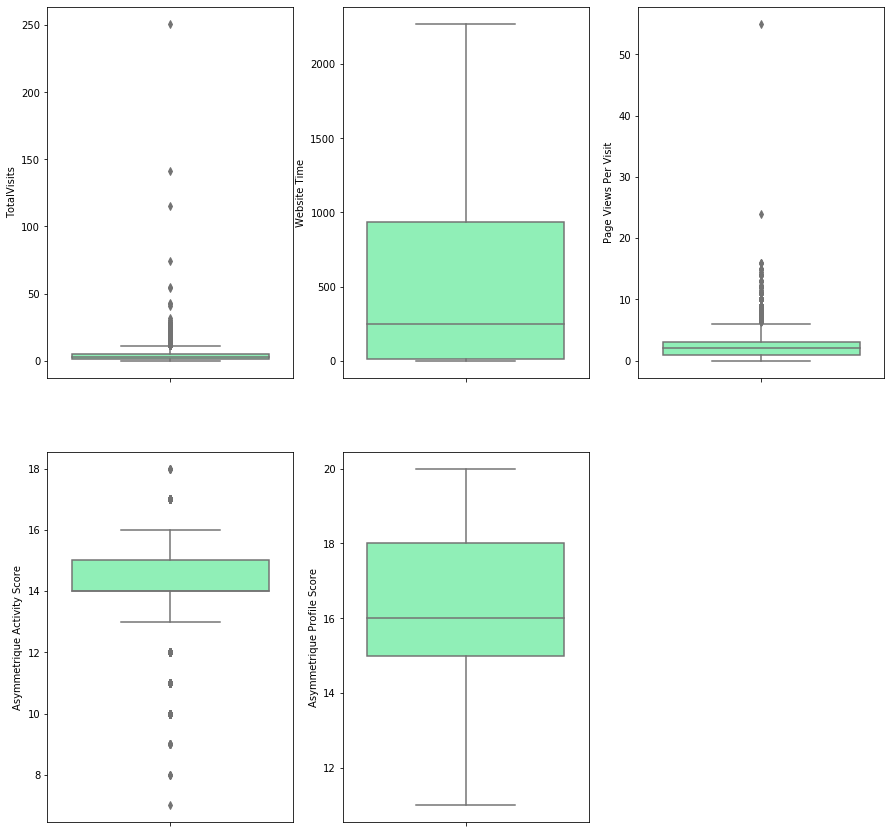

In [234]:
plt.figure(figsize=(15,15))
for col in num_cols:
    plt.subplot(2,3,num_cols.index(col)+1)
    sns.boxplot(y=col,data=lead_data,palette='rainbow')

#### Observation:
Total Visits and Page views per visit have Outliers

In [235]:
lead_data[['TotalVisits','Page Views Per Visit']].describe(percentiles=(0.95,0.99))

,TotalVisits,Page Views Per Visit
count,9240.000000,9240.000000
mean,3.438636,2.357440
std,4.819024,2.145781
min,0.000000,0.000000
50%,3.000000,2.000000
95%,10.000000,6.000000
99%,17.000000,9.000000
max,251.000000,55.000000


In [236]:
lead_data['TotalVisits'].value_counts(ascending=False)

## capping at 99% value - 17

lead_data.loc[lead_data['TotalVisits']>17,['TotalVisits']]=17

In [237]:
lead_data['TotalVisits'].value_counts(ascending=False)

0.0     2189
2.0     1680
3.0     1443
4.0     1120
5.0      783
6.0      466
1.0      395
7.0      309
8.0      224
9.0      164
10.0     114
17.0      99
11.0      86
13.0      48
12.0      45
14.0      36
16.0      21
15.0      18
Name: TotalVisits, dtype: int64

In [238]:
## Capping at 99% value - 9

lead_data.loc[lead_data['Page Views Per Visit']>9,'Page Views Per Visit']=9
lead_data['Page Views Per Visit'].value_counts()

0.00    2189
2.00    1932
3.00    1196
4.00     896
1.00     651
        ... 
2.38       1
8.50       1
1.31       1
3.43       1
1.64       1
Name: Page Views Per Visit, Length: 102, dtype: int64

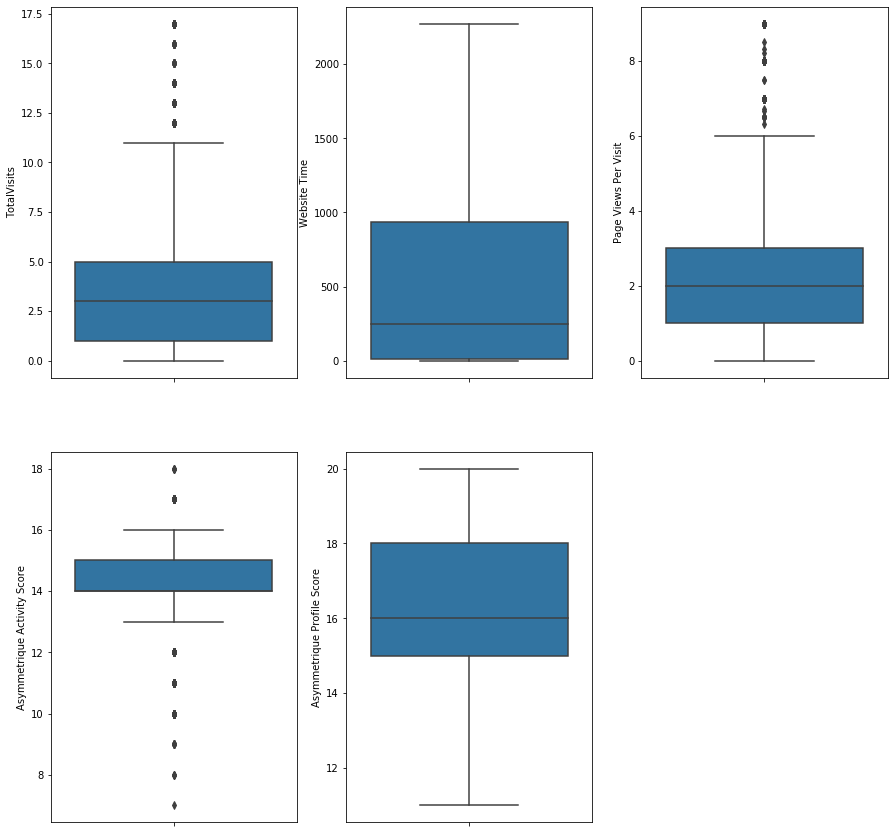

In [239]:
## Replotting the box plots

plt.figure(figsize=(15,15))
for col in num_cols:
    plt.subplot(2,3,num_cols.index(col)+1)
    sns.boxplot(y=col,data=lead_data)


#### 2.5 Check for duplicates<a id='step2.5'></a>

#### 2.6 Check for data type conversion<a id='step2.6'></a>

In [240]:
lead_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                 9240 non-null object
Lead Number                                 9240 non-null int64
Lead Origin                                 9240 non-null object
Lead Source                                 9240 non-null object
Do Not Email                                9240 non-null object
Do Not Call                                 9240 non-null object
Converted                                   9240 non-null int64
TotalVisits                                 9240 non-null float64
Website Time                                9240 non-null int64
Page Views Per Visit                        9240 non-null float64
Last Activity                               9137 non-null object
Country                                     9240 non-null object
Specialization                              9240 non-null object
How did you hear about X Education          7033 

#### Observation : 
No datatype conversion required

## Step 3. Preprocessing and Data Preparation<a id='step3'></a>
#### 3.1 Adding Derived variables<a id='step3.1'></a>
#### 3.2 Categorizing variables<a id='step3.2'></a>
#### 3.3 Creating dummy variables<a id='step3.3'></a>
#### 3.4 Dropping unncessary Columns<a id='step3.4'></a>

#### 3.3 Creating dummy variables <a id='step3.3' ></a>

In [241]:
### Creating dummies for binary columns with Yes/No values
binary_cols=['Do Not Email','Do Not Call','Through Recommendations','Free copy required']
binary_cols

['Do Not Email',
 'Do Not Call',
 'Through Recommendations',
 'Free copy required']

In [242]:
for col in binary_cols:
    lead_data[col]=lead_data[col].map({'Yes':1,'No':0})

In [243]:
lead_data['Do Not Email'].value_counts()
#print(lead_data['Do Not Call'].value_counts())

0    8506
1     734
Name: Do Not Email, dtype: int64

In [244]:
lead_data['Do Not Call'].value_counts()

0    9238
1       2
Name: Do Not Call, dtype: int64

In [245]:
lead_data['Through Recommendations'].value_counts()

0    9233
1       7
Name: Through Recommendations, dtype: int64

In [246]:
lead_data['Free copy required'].value_counts()

0    6352
1    2888
Name: Free copy required, dtype: int64